/tmp/ipykernel_186057/586424940.py:162: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral, _ = quad(integrand, E, E_upper, limit=1000, epsabs=0, epsrel=1e-3)


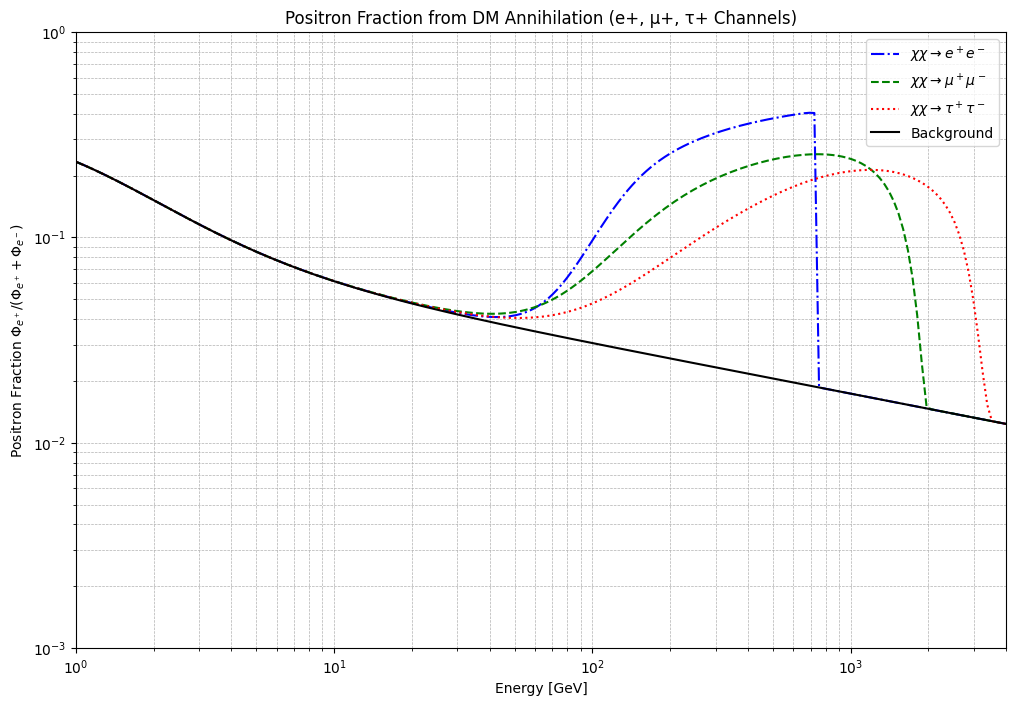

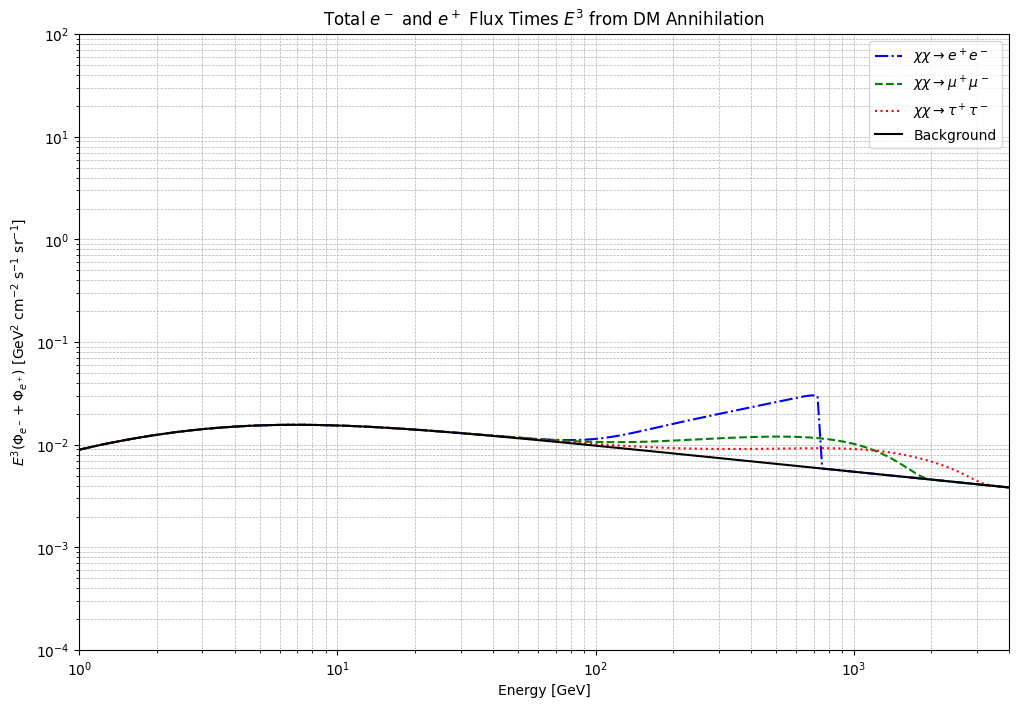

In [29]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

#From the Pallis paper
rho_0 = 0.3  # GeV/cm^3 (local CDM density)
alpha_em = 1 / 137  # Fine-structure constant
m_e = 0.511e-3  # Electron mass in GeV
c = 3e10  # Speed of light in cm/s
t_E = 1e16  # Energy loss time in seconds

# Converting the sigma_v (but I'm including the 1e-7 here)
cross_section_factor = 1e-7 * 0.3894e-27 * c  # Converts GeV^-2 to cm^3/s

# For tau tau from the paper
A0_tau, A1_tau, A2_tau, A3_tau = 0.951, -18.083, 15.79, -15.575
A0p_tau, A1p_tau, A2p_tau, A3p_tau, A4p_tau, A5p_tau = (
    2.783,
    -22.942,
    82.595,
    -193.748,
    223.389,
    -97.716,
)

# Gaussian approximation of Dirac delta function after many trials
def delta_gauss(E, m_chi, width=1e-3):
    return (1 / (width * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((E - m_chi) / width) ** 2)

# Loss function 
def b(E):
    return E**2 / t_E  # Units: GeV s^{-1}

# Positron velocity 
def v_e(E):
    beta = np.sqrt(1 - (m_e / E)**2) if E > m_e else 0
    return c * beta  # in cm/s

# Halo function (Eq. 4.3)
def lambda_D(E, E_prime, K0=0.0112, delta=0.70):
    # K0 is in kpc^2/Myr, t_E in s, E in GeV
    # Convert K0 from kpc^2/Myr to cm^2/s
    K0_cgs = K0 * (3.086e21)**2 / (3.15576e13)  # kpc^2/Myr to cm^2/s
    E_factor = (E_prime**(delta - 1) - E**(delta - 1)) / (delta - 1)
    return np.sqrt(4 * K0_cgs * t_E * E_factor)  # Units: cm

# (Eq. 4.4)
def I(lambda_D, model="MED"):
    if model == "MED":
        a0, a1, a2, a3 = 0.506, 0.616, 0.140, 0.801
        b1, b2, c1, c2 = 0.796, 0.485, 0.191, 0.283
    elif model == "MIN":
        a0, a1, a2, a3 = 0.5, 0.903, -0.449, 0.557
        b1, b2, c1, c2 = 0.096, 192.8, 0.210, 33.91
    else:
        raise ValueError("error")

    # Convert lambda_D from cm to kpc
    lambda_D_kpc = lambda_D / 3.086e21  # cm to kpc

    #  l = log(lambda_D / 1 kpc)
    l = np.log(lambda_D_kpc / 1.0)
    c2 = np.abs(c2)

    return a0 + a1 * np.tanh((b1 - l) / c1) * (
        a2 * np.exp(-((l - b2) ** 2) / c2) + a3
    )

# for muon channel
def compute_muon_params(m_chi):
    # Scaling factor as per the paper but in GeV
    scaling = m_chi / 500  
    
    # Exponents from the paper
    delta_A, delta_A1, delta_A2, delta_B1, delta_B2 = (
        -1.01424,
        0.017198,
        -0.0107585,
        -0.999819,
        -0.999819,
    )
    
    # Tilde parameters from the paper
    tilde_A, tilde_A1, tilde_A2, tilde_B1, tilde_B2 = (
        -0.296635,
        2.65121,
        14.8445,
        0.0042505,
        -0.00427157,
    )

    # The parameters J
    A = tilde_A * scaling ** delta_A
    A1_mu = tilde_A1 * scaling ** delta_A1
    A2_mu = tilde_A2 * scaling ** delta_A2
    B1_mu = tilde_B1 * scaling ** delta_B1
    B2_mu = tilde_B2 * scaling ** delta_B2

    return A, A1_mu, A2_mu, B1_mu, B2_mu

# Equation 4.2 for different annihilation channels
def dNe_dEe(E, m_chi, channel="e", params=None):
    y = E / m_chi  # y = E/m_chi

    if channel == "e":  #electron channel
        # Gaussian approximation for Dirac delta function
        delta_width = 1e-3  # Small width in GeV
        delta_term = delta_gauss(E, m_chi, width=delta_width)
        # Final State Radiation (FSR) contribution
        # In case y is very close to 1
        if np.isclose(y, 1.0, atol=1e-6) or y > 1.0:
            fsr_term = 0.0
        else:
            fsr_term = (
                (alpha_em / (2 * np.pi))
                * ((1 + y**2) / (1 - y))
                * np.log(4 * m_chi**2 / m_e**2)
            ) / m_chi
        return delta_term + fsr_term

    elif channel == "mu":  # muon channel
        A, A1_mu, A2_mu, B1_mu, B2_mu = params
        term1 = (alpha_em / np.pi) * A * np.exp(
            -(A1_mu * y + A2_mu * y**2)
        )  # Units: GeV^{-1}
        term2 = B1_mu + B2_mu * y  # Units: GeV^{-1}
        return term1 + term2

    elif channel == "tau":  # tau channel
        exp1 = np.exp(
            A0_tau + A1_tau * y + A2_tau * y**2 + A3_tau * y**3
        )
        exp2 = np.exp(
            A0p_tau
            + A1p_tau * y
            + A2p_tau * y**2
            + A3p_tau * y**3
            + A4p_tau * y**4
            + A5p_tau * y**5
        )
        return (exp1 + exp2) / m_chi  # Units: GeV^{-1}

    else:
        raise ValueError("error")

# Flux equation (Eq. 4.1)
def flux(E, m_chi, sigma_v, channel="e", model="MED", params=None):
    # Small epsilon to avoid division by zero at the upper limit
    epsilon = 1e-6  # GeV

    def integrand(E_prime):
        lam_D = lambda_D(E, E_prime)
        integrand_value = I(lam_D, model=model) * dNe_dEe(
            E_prime, m_chi, channel=channel, params=params
        )
        return integrand_value

    # Adjust the upper limit to m_chi - epsilon
    E_upper = m_chi - epsilon if channel == "e" else m_chi

    # Integration limits from E to E_upper
    integral, _ = quad(integrand, E, E_upper, limit=1000, epsabs=0, epsrel=1e-3)

    prefactor = (
        v_e(E) / (4 * np.pi * b(E))
    ) * (rho_0 / m_chi) ** 2 * sigma_v / 2

    return prefactor * integral  # Units: cm^{-2} s^{-1} sr^{-1} GeV^{-1}

# Background fluxes (Eq. 4.6a, 4.6b, 4.6c)
def background_flux(E):
    # Secondary positron flux (Eq. 4.6a)
    Phi_sec_eplus = (
        4.5
        * (E / 1.0) ** 0.7
        / (
            1
            + 650 * (E / 1.0) ** 2.3
            + 1500 * (E / 1.0) ** 4.2
        )
    )

    # Primary electron flux (Eq. 4.6b)
    Phi_prim_eminus = (
        0.16
        * (E / 1.0) ** -1.1
        / (
            1
            + 11 * (E / 1.0) ** 0.9
            + 3.2 * (E / 1.0) ** 2.15
        )
    )

    # Secondary electron flux (Eq. 4.6c)
    Phi_sec_eminus = (
        0.70
        * (E / 1.0) ** 0.7
        / (
            1
            + 110 * (E / 1.0) ** 1.5
            + 600 * (E / 1.0) ** 2.9
            + 580 * (E / 1.0) ** 4.2
        )
    )

    return Phi_sec_eplus, Phi_prim_eminus, Phi_sec_eminus

# Total positron flux for each channel
def total_flux_channel(energies, m_chi, sigma_v, channel, model="MED"):
    flux_eplus = []

    # For muon channel, compute mass-dependent parameters once
    if channel == "mu":
        params = compute_muon_params(m_chi)
    else:
        params = None

    for E in energies:
        if E >= m_chi:
            flux_eplus.append(0.0)
            continue
        Phi_DM = flux(E, m_chi, sigma_v, channel, model, params)
        flux_eplus.append(Phi_DM)

    return np.array(flux_eplus)

# Calculate combined background fluxes
def total_background_flux(energies, c_e=0.6):
    flux_eplus_bg = []
    flux_eminus_bg = []

    for E in energies:
        Phi_sec_eplus, Phi_prim_eminus, Phi_sec_eminus = background_flux(E)
        flux_eplus_bg.append(Phi_sec_eplus)
        flux_eminus_bg.append(
            c_e * Phi_prim_eminus + Phi_sec_eminus
        )

    return np.array(flux_eplus_bg), np.array(flux_eminus_bg)

# Now call the total_flux_channel function with parameters from the table
energies = np.logspace(0, np.log10(4000), 200)  # Energy range from 1 to 4000 GeV

# Masses and cross-sections from the table (in GeV and cm^3/s units)
params_table = {
    "e": {"m_chi": 0.74e3, "sigma_v": 7 * cross_section_factor},
    "mu": {"m_chi": 2e3, "sigma_v": 28.6 * cross_section_factor},
    "tau": {"m_chi": 3.5e3, "sigma_v": 143 * cross_section_factor},
}

# Positron flux for each channel
flux_eplus_e = total_flux_channel(
    energies, params_table["e"]["m_chi"], params_table["e"]["sigma_v"], "e", model="MED"
)
flux_eplus_mu = total_flux_channel(
    energies,
    params_table["mu"]["m_chi"],
    params_table["mu"]["sigma_v"],
    "mu",
    model="MED",
)
flux_eplus_tau = total_flux_channel(
    energies,
    params_table["tau"]["m_chi"],
    params_table["tau"]["sigma_v"],
    "tau",
    model="MIN",
)

# Since Φ_DM^{e-} = Φ_DM^{e+}
flux_eminus_e = flux_eplus_e
flux_eminus_mu = flux_eplus_mu
flux_eminus_tau = flux_eplus_tau

# Calculate combined background fluxes
flux_eplus_bg, flux_eminus_bg = total_background_flux(energies, c_e=0.6) #c_e from the paper 
# Total fluxes including DM contributions
total_flux_e_eplus = flux_eplus_e + flux_eplus_bg
total_flux_mu_eplus = flux_eplus_mu + flux_eplus_bg
total_flux_tau_eplus = flux_eplus_tau + flux_eplus_bg

total_flux_e_eminus = flux_eminus_e + flux_eminus_bg
total_flux_mu_eminus = flux_eminus_mu + flux_eminus_bg
total_flux_tau_eminus = flux_eminus_tau + flux_eminus_bg

# Positron fractions for each channel
pos_frac_e = (flux_eplus_e + flux_eplus_bg) / (
    flux_eplus_e + flux_eminus_e + flux_eplus_bg + flux_eminus_bg
)
pos_frac_mu = (flux_eplus_mu + flux_eplus_bg) / (
    flux_eplus_mu + flux_eminus_mu + flux_eplus_bg + flux_eminus_bg
)
pos_frac_tau = (flux_eplus_tau + flux_eplus_bg) / (
    flux_eplus_tau + flux_eminus_tau + flux_eplus_bg + flux_eminus_bg
)
pos_frac_bg = flux_eplus_bg / (flux_eplus_bg + flux_eminus_bg)

# Plot the positron fraction similar to the paper
plt.figure(figsize=(12, 8))

# Plot positron fraction for each channel
plt.plot(
    energies,
    pos_frac_e,
    label=r"$\chi\chi \to e^+e^-$",
    linestyle="-.",
    color="blue",
)
plt.plot(
    energies,
    pos_frac_mu,
    label=r"$\chi\chi \to \mu^+\mu^-$",
    linestyle="--",
    color="green",
)
plt.plot(
    energies,
    pos_frac_tau,
    label=r"$\chi\chi \to \tau^+\tau^-$",
    linestyle=":",
    color="red",
)

# Plot background positron fraction
plt.plot(
    energies,
    pos_frac_bg,
    label="Background",
    linestyle="-",
    color="black",
)

plt.xlabel("Energy [GeV]")
plt.ylabel(r"Positron Fraction $\Phi_{e^+} / (\Phi_{e^+} + \Phi_{e^-})$")
plt.legend()
plt.title("Positron Fraction from DM Annihilation (e+, μ+, τ+ Channels)")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 4000)
plt.ylim(1e-3, 1)
plt.show()

# Total electron and positron flux times E^3 
plt.figure(figsize=(12, 8))

# Compute total flux times E^3 for each channel
E3_total_flux_e = energies**3 * (total_flux_e_eplus + total_flux_e_eminus)
E3_total_flux_mu = energies**3 * (total_flux_mu_eplus + total_flux_mu_eminus)
E3_total_flux_tau = energies**3 * (total_flux_tau_eplus + total_flux_tau_eminus)
E3_total_flux_bg = energies**3 * (flux_eplus_bg + flux_eminus_bg)

# Total flux times E^3 for each channel
plt.plot(
    energies,
    E3_total_flux_e,
    label=r"$\chi\chi \to e^+e^-$",
    linestyle="-.",
    color="blue",
)
plt.plot(
    energies,
    E3_total_flux_mu,
    label=r"$\chi\chi \to \mu^+\mu^-$",
    linestyle="--",
    color="green",
)
plt.plot(
    energies,
    E3_total_flux_tau,
    label=r"$\chi\chi \to \tau^+\tau^-$",
    linestyle=":",
    color="red",
)
# Background total flux times E^3
plt.plot(
    energies,
    E3_total_flux_bg,
    label="Background",
    linestyle="-",
    color="black",
)

plt.xlabel("Energy [GeV]")
plt.ylabel(r"$E^3 (\Phi_{e^-} + \Phi_{e^+})$ [GeV$^{2}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]")
plt.legend()
plt.title("Total $e^-$ and $e^+$ Flux Times $E^3$ from DM Annihilation")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 4000)
plt.ylim(1e-4, 1e2)
plt.show()
